In [2]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt


In [3]:
# Importing names/words

words = open('makemore/names.txt','r').read().splitlines() # split each line and create list of each lines

In [4]:
words[:3]

['emma', 'olivia', 'ava']

In [6]:
char = sorted(list(set(''.join(words)))) # All characters from words
char

['a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z']

In [10]:
# String to integer dictionary
stoi = {s:i+1 for i,s in enumerate(char)}
stoi['.']=0

# Integer to string dictionary
itos = {i:s for s,i in stoi.items()}
itos

{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 0: '.'}

In [12]:
[0]*3   # Padding/for initialisation

[0, 0, 0]

In [25]:
# Building the datasets

block_size = 3   # Context length given as input to predict the next character

xs = []   # Input 
ys = []   # Output

context = [0] * block_size      # Initializing([0,0,0] ----->  ...)

for w in words[:5]:
    print(w)
    for ch in w+'.':           # Looping each word and appending '.' at the end
        ix = stoi[ch]
        xs.append(context)
        ys.append(ix)
        print(''.join(itos[x] for x in context), '---->', ch)
        
        context = context[1:]+[ix]
X = torch.tensor(xs)
Y = torch.tensor(ys)

emma
... ----> e
..e ----> m
.em ----> m
emm ----> a
mma ----> .
olivia
ma. ----> o
a.o ----> l
.ol ----> i
oli ----> v
liv ----> i
ivi ----> a
via ----> .
ava
ia. ----> a
a.a ----> v
.av ----> a
ava ----> .
isabella
va. ----> i
a.i ----> s
.is ----> a
isa ----> b
sab ----> e
abe ----> l
bel ----> l
ell ----> a
lla ----> .
sophia
la. ----> s
a.s ----> o
.so ----> p
sop ----> h
oph ----> i
phi ----> a
hia ----> .


In [26]:
X.shape, Y.shape  # Input shape : no. of 3 characters combination extracted from 5 words

(torch.Size([32, 3]), torch.Size([32]))

In [28]:
## Now we create a embedding layer of 2 columns for every 27 possible character outputs to embed with the input layer

C = torch.randn((27,2))


emb = C[X]    # Embedding layer with inputs - by indexing, the same can be achieved through one-hot encoding which
              # is commented below

emb.shape


torch.Size([32, 3, 2])

In [29]:
F.one_hot(torch.tensor(5), num_classes=27)

tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0])

In [39]:
F.one_hot(torch.tensor(5), num_classes=27).float() @ C    # will give the 5th element in C - one-hot encoding
                                                                                   # and matrix multiplication


tensor([-0.0916, -0.8972])

In [33]:
C[5]         # which is the same as indexing the 5th element of embedding 

tensor([-0.0916, -0.8972])

In [35]:
emb[13,2]

tensor([-1.3579, -2.6002])

In [36]:
X[13,2]

tensor(1)

In [37]:
C[1]

tensor([-1.3579, -2.6002])

In [38]:
C[X][13,2]               # Same for different approaches. Get the intuition

tensor([-1.3579, -2.6002])

In [61]:
## Now we wanted to create weights and bias of neurons for the next layer

####### HIDDEN LAYER ###########

# Weights for 100 neurons with 6 input neurons
W1 = torch.randn((6,100))    # Note input is 6 rows = 3*2, since we have 2 column embedding each for 2 charater combinatio as i/p

# Bias
b1 = torch.randn(100)       # bias for 100 neurons


In [41]:
emb.shape

torch.Size([32, 3, 2])

In [62]:
# We cannot directly do matrix multiplication as emb @ W + b, since emb is (32x3x2) and (6x100) is not compatible

# So we will flatten the embedding layer to 32x6, by concatenating columns

h = torch.tanh(emb.view(-1,6) @ W1 +b1)  # which is same as emb.view(emb.shape[0],6) ---> here emb.shape[0] = 32
                                         # tanh ---> nonlinearity

In [43]:
emb[:,0,:].shape,emb[:,1,:].shape,emb[:,2,:].shape

(torch.Size([32, 2]), torch.Size([32, 2]), torch.Size([32, 2]))

In [46]:
# torch concatenation
torch.cat((emb[:,0,:],emb[:,1,:],emb[:,2,:]), dim=1).shape

torch.Size([32, 6])

In [52]:
# Another way to concatenate, first we unbind the second index and then concatenate, here we dont want to specify
# manually the no. of dimensions as before. By default, torch.unbind has dim 0
print(len(torch.unbind(emb, dim=1)))

torch.cat(torch.unbind(emb, dim=1), dim=1).shape

3


torch.Size([32, 6])

In [53]:
# Another efficient way is using torch.view

emb.view(32,6)


tensor([[-0.0178, -1.2964, -0.0178, -1.2964, -0.0178, -1.2964],
        [-0.0178, -1.2964, -0.0178, -1.2964, -0.0916, -0.8972],
        [-0.0178, -1.2964, -0.0916, -0.8972,  0.6454,  0.1228],
        [-0.0916, -0.8972,  0.6454,  0.1228,  0.6454,  0.1228],
        [ 0.6454,  0.1228,  0.6454,  0.1228, -1.3579, -2.6002],
        [ 0.6454,  0.1228, -1.3579, -2.6002, -0.0178, -1.2964],
        [-1.3579, -2.6002, -0.0178, -1.2964, -1.3496,  1.2758],
        [-0.0178, -1.2964, -1.3496,  1.2758, -2.0284,  0.6533],
        [-1.3496,  1.2758, -2.0284,  0.6533,  0.0216, -0.2812],
        [-2.0284,  0.6533,  0.0216, -0.2812,  0.9456,  0.5711],
        [ 0.0216, -0.2812,  0.9456,  0.5711,  0.0216, -0.2812],
        [ 0.9456,  0.5711,  0.0216, -0.2812, -1.3579, -2.6002],
        [ 0.0216, -0.2812, -1.3579, -2.6002, -0.0178, -1.2964],
        [-1.3579, -2.6002, -0.0178, -1.2964, -1.3579, -2.6002],
        [-0.0178, -1.2964, -1.3579, -2.6002,  0.9456,  0.5711],
        [-1.3579, -2.6002,  0.9456,  0.5

In [54]:
emb.view(32,6).shape

torch.Size([32, 6])

In [55]:
# Element wise checking
emb.view(32,6) == torch.cat(torch.unbind(emb, dim=1), dim=1)

tensor([[True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, T

In [58]:
(emb.view(32,6) @ W1).shape  # 32x6 @ 6x100 -----> 32x100

torch.Size([32, 100])

In [59]:
h.shape

torch.Size([32, 100])

In [64]:
### Now add a second hidden layer of 27 neurons(possible o/p char) which has 100 input features(h-no. of columns) from the previous layer

# weights
W2 = torch.randn((100,27))   # I/p 100 rows, O/p 27 columns - no. of neurons - for each possible o/p char
 
# bias
b2 = torch.randn(27)

In [67]:
logits = h @ W2 + b2
logits.shape

torch.Size([32, 27])

In [69]:
# Converting logits into probabilities
counts = logits.exp()
probs = counts/counts.sum(1, keepdims=True)

In [70]:
probs.shape, probs[0].sum() # Check

(torch.Size([32, 27]), tensor(1.0000))

In [71]:
torch.arange(X.shape[0])

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

In [72]:
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

In [77]:
# predicted probability of Y before training the model

probs[torch.arange(X.shape[0]), Y] # here the o/p probabilites should be maximum, for the selected char,
                                   # Next we will define the loss function to train the model to increase the 
                                   # predicted probability or minimize the negative log likelihood

tensor([1.8562e-04, 4.9862e-03, 1.2301e-05, 7.3984e-06, 6.1696e-08, 4.2367e-11,
        3.1807e-08, 1.3754e-07, 1.4895e-12, 5.6812e-16, 3.4800e-05, 9.4566e-05,
        1.5365e-10, 2.7568e-07, 2.1233e-06, 1.9076e-10, 3.7493e-01, 1.3482e-11,
        3.3565e-14, 4.2974e-01, 5.4597e-01, 6.9704e-04, 1.3695e-06, 8.5977e-15,
        1.8524e-05, 2.8999e-14, 5.6008e-09, 1.5102e-06, 1.5698e-10, 2.8063e-14,
        7.7532e-08, 1.5016e-07])

In [75]:
probs[torch.arange(X.shape[0]), Y].shape  # predicted output probability

torch.Size([32])

In [79]:
# Loss to minimize - negative log likelihood
loss = -probs[torch.arange(X.shape[0]), Y].log().mean()
loss

tensor(16.7985)

### All put together

In [80]:
X.shape, Y.shape    # Dataset

(torch.Size([32, 3]), torch.Size([32]))

In [85]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [86]:
sum(p.nelement() for p in parameters) # total no. of parameters

3481

In [99]:
# Forward pass

emb = C[X] # 32x3x2
h = torch.tanh(emb.view(-1,6) @ W1 +b1) # 32x100
logits = h @ W2 + b2 # 32x27

# Converting logits into probabilities
# counts = logits.exp()
# probs = counts/counts.sum(1, keepdims=True)
# loss = -probs[torch.arange(X.shape[0]), Y].log().mean()

# the above commented steps can be simplified and can be calculated efficiently using F.crossentropy
loss = F.cross_entropy(logits,Y)
loss

tensor(17.9138, grad_fn=<NllLossBackward0>)

In [94]:
for p in parameters:
    p.requires_grad = True

In [100]:
# Backward pass

for p in parameters:
    p.grad = None
loss.backward()
for p in parameters:
    p.data += -0.1 * p.grad

In [103]:
## Put together

for i in range(100):
    
    #minibatch construction 
    ix = torch.randint(0, X.shape[0], (32,))
    
    # Forward pass
    emb = C[X] # 32x3x2
    h = torch.tanh(emb.view(-1,6) @ W1 +b1) # 32x100
    logits = h @ W2 + b2 # 32x27
    
    loss = F.cross_entropy(logits,Y)
    print(loss.item())
    
    # Backward pass

    for p in parameters:
        p.grad = None
    loss.backward()
    for p in parameters:
        p.data += -0.1 * p.grad
    
    
    

0.09068124741315842
0.08945374935865402
0.08825261145830154
0.0870770663022995
0.08592602610588074
0.08479874581098557
0.08369456231594086
0.08261249959468842
0.08155222982168198
0.08051285147666931
0.0794939324259758
0.07849489152431488
0.07751495391130447
0.07655398547649384
0.07561105489730835
0.07468611747026443
0.07377862930297852
0.07288781553506851
0.0720137357711792
0.0711558535695076
0.07031374424695969
0.06948712468147278
0.06867547333240509
0.06787864118814468
0.06709617376327515
0.06632779538631439
0.06557326018810272
0.06483227759599686
0.06410441547632217
0.0633896142244339
0.06268749386072159
0.0619976744055748
0.06132009997963905
0.06065430864691734
0.06000019237399101
0.05935748293995857
0.05872616916894913
0.05810564011335373
0.05749575421214104
0.056896455585956573
0.056307386606931686
0.05572844296693802
0.05515936017036438
0.05459986999630928
0.054049912840127945
0.05350912734866142
0.05297750607132912
0.05245478078722954
0.05194089561700821
0.051435381174087524
0.

In [102]:
# minibatch construction
torch.randint(0,15,(32,)) # integer values containing no.s between 0 and 14 with length 32

tensor([14, 14,  5, 11,  4,  0, 11,  3,  0,  0,  6,  8,  8, 14,  1,  8, 11,  9,
         3, 10,  6,  2,  0, 13, 10,  0,  6, 11,  6,  7,  7, 10])

In [104]:
# learning rate stats
lre = torch.linspace(-3, 0, 1000) # will uniformly distribute numbers from -3 to 0 of length 1000
lrs = 10**lre # ranges from 10^-3 = 0.001 to 10^0 = 1
lrs

tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012,
        0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0014,
        0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014,
        0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
        0.0015, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016,
        0.0016, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017,
        0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0019,
        0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0021, 0.0021, 0.0021, 0.0021,
        0.0021, 0.0021, 0.0021, 0.0022, 

### Full Dataset implementation

In [106]:
## Building the full dataset

block_size = 3   # Context length given as input to predict the next character

xs = []   # Input 
ys = []   # Output

context = [0] * block_size      # Initializing([0,0,0] ----->  ...)

for w in words:
    #print(w)
    for ch in w+'.':           # Looping each word and appending '.' at the end
        ix = stoi[ch]
        xs.append(context)
        ys.append(ix)
        #print(''.join(itos[x] for x in context), '---->', ch)
        
        context = context[1:]+[ix]
X = torch.tensor(xs)
Y = torch.tensor(ys)
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [144]:
# parameters

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

sum(p.nelement() for p in parameters) # total no. of parameters

3481

In [109]:
for i in range(100):
    
    # without minibatch construction 
    #ix = torch.randint(0, X.shape[0], (32,))
    
    # Forward pass
    emb = C[X] # 32x3x2
    h = torch.tanh(emb.view(-1,6) @ W1 +b1) # 32x100
    logits = h @ W2 + b2 # 32x27
    
    loss = F.cross_entropy(logits,Y)
    print(loss.item())
    
    # Backward pass

    for p in parameters:
        p.grad = None
    loss.backward()
    for p in parameters:
        p.data += -0.1 * p.grad



19.235767364501953
18.205915451049805
17.299163818359375
16.491422653198242
15.758024215698242
15.081761360168457
14.455562591552734
13.87472915649414
13.335487365722656
12.834826469421387
12.369384765625
11.93510627746582
11.527636528015137
11.143498420715332
10.78066349029541
10.438188552856445
10.11551570892334
9.811924934387207
9.52639102935791
9.257647514343262
9.004352569580078
8.76517105102539
8.53883171081543
8.324150085449219
8.120044708251953
7.925548553466797
7.739816665649414
7.5621256828308105
7.391858100891113
7.2285027503967285
7.071643829345703
6.920961856842041
6.7762346267700195
6.637335300445557
6.504217624664307
6.376903057098389
6.255456924438477
6.139946460723877
6.030383586883545
5.926677227020264
5.828599452972412
5.735795497894287
5.647833347320557
5.564259052276611
5.484633922576904
5.408568382263184
5.335726261138916
5.265825271606445
5.198625564575195
5.133928298950195
5.071559906005859
5.011373519897461
4.953241348266602
4.897049903869629
4.842696666717529


In [117]:
for i in range(100):
    
    # with minibatch construction 
    ix = torch.randint(0, X.shape[0], (32,))  # Gradient oscillates but calculation is faster
    
    # Forward pass
    emb = C[X[ix]] # 32x3x2
    h = torch.tanh(emb.view(-1,6) @ W1 +b1) # 32x100
    logits = h @ W2 + b2 # 32x27
    
    loss = F.cross_entropy(logits,Y[ix])
    print(loss.item())
    
    # Backward pass

    for p in parameters:
        p.grad = None
    loss.backward()
    for p in parameters:
        p.data += -0.1 * p.grad

19.320125579833984
17.22045135498047
14.70096206665039
15.035167694091797
19.60096549987793
14.961915016174316
13.901679992675781
13.000765800476074
13.970040321350098
13.72057819366455
9.860956192016602
12.016027450561523
13.155502319335938
12.895930290222168
10.829681396484375
12.06806755065918
8.836010932922363
10.307255744934082
10.65571117401123
9.116101264953613
9.745967864990234
10.037481307983398
7.277383327484131
8.791037559509277
8.098334312438965
7.412832260131836
7.477203369140625
7.157872200012207
7.70289945602417
7.83073616027832
6.922931671142578
5.434125900268555
7.270839691162109
6.099024772644043
5.092657089233398
5.816243648529053
4.402143955230713
6.312825679779053
5.607986927032471
5.023168563842773
6.340659141540527
5.702691078186035
6.344951152801514
6.911418914794922
4.665240287780762
5.206332206726074
5.831378936767578
6.2380146980285645
5.332345008850098
5.820827484130859
4.056064128875732
4.215328216552734
4.503229141235352
4.6998162269592285
4.9002685546875


In [118]:
# learning rate stats
lre = torch.linspace(-3, 0, 1000) # will uniformly distribute numbers from -3 to 0 of length 1000
lrs = 10**lre # ranges from 10^-3 = 0.001 to 10^0 = 1

In [127]:
lri = []
lrei = []
lossi = []

for i in range(1000):
    
    # with minibatch construction 
    ix = torch.randint(0, X.shape[0], (32,))  # Gradient oscillates but calculation is faster
    
    # Forward pass
    emb = C[X[ix]] # 32x3x2
    h = torch.tanh(emb.view(-1,6) @ W1 +b1) # 32x100
    logits = h @ W2 + b2 # 32x27
    
    loss = F.cross_entropy(logits,Y[ix])
    #print(loss.item())
    lri.append(lrs[i])
    lossi.append(loss.item())
    lrei.append(lre[i])
    
    # Backward pass

    for p in parameters:
        p.grad = None
    loss.backward()
    for p in parameters:
        p.data += -lrs[i] * p.grad
        
        
        
    

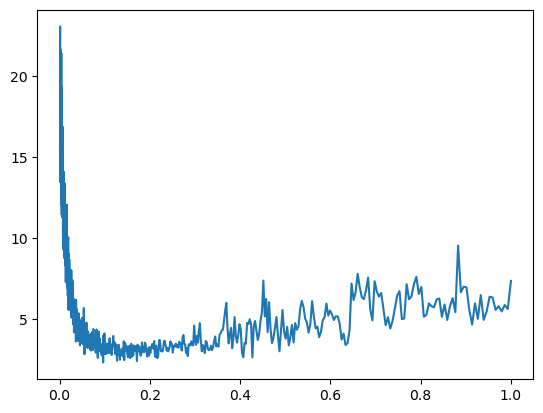

In [128]:
plt.plot(lri,lossi)

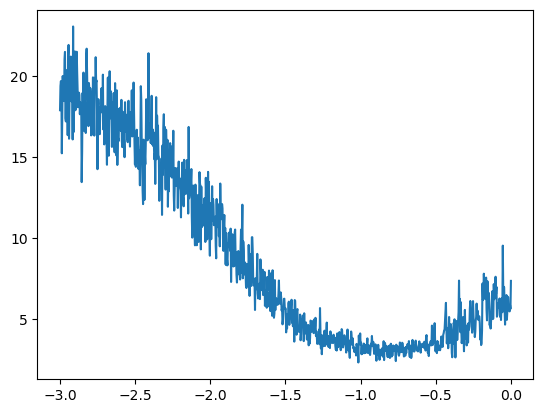

In [131]:
plt.plot(lrei,lossi) # plotting the exponents

In [140]:
# lri = []
# lrei = []
# lossi = []
# Updating the learning rate to 0.01 based on statistics

for i in range(1000):
    
    # with minibatch construction 
    ix = torch.randint(0, X.shape[0], (32,))  # Gradient oscillates but calculation is faster
    
    # Forward pass
    emb = C[X[ix]] # 32x3x2
    h = torch.tanh(emb.view(-1,6) @ W1 +b1) # 32x100
    logits = h @ W2 + b2 # 32x27
    
    loss = F.cross_entropy(logits,Y[ix])
    #print(loss.item())
    #lri.append(lrs[i])
    #lossi.append(loss.item())
    #lrei.append(lre[i])
    
    # Backward pass
    
    #lr = lrs[i]
    lr = 0.1
    
    for p in parameters:
        p.grad = None
    loss.backward()
    for p in parameters:
        p.data += -lr * p.grad
        

In [141]:
loss.item()  # for last iterations, we can reduce lr to reduce loss further

2.3219008445739746

### Splitting datasets into train - 80%, dev/val - 10%, test - 10%


In [142]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [143]:
print(f'total words - {len(words)}, training words - {n1}, val words - {n2-n1}, test words - {len(words)-n2}')

total words - 32033, training words - 25626, val words - 3203, test words - 3204


In [145]:
# Training only on train datasets (Xtr,Ytr)

for i in range(30000):
    
    # with minibatch construction 
    ix = torch.randint(0, Xtr.shape[0], (32,))  # Gradient oscillates but calculation is faster
    
    # Forward pass
    emb = C[Xtr[ix]] # 32x3x2
    h = torch.tanh(emb.view(-1,6) @ W1 +b1) # 32x100
    logits = h @ W2 + b2 # 32x27
    
    loss = F.cross_entropy(logits,Ytr[ix])
    #print(loss.item())
    #lri.append(lrs[i])
    #lossi.append(loss.item())
    #lrei.append(lre[i])
    
    # Backward pass
    
    #lr = lrs[i]
    lr = 0.1
    
    for p in parameters:
        p.grad = None
    loss.backward()
    for p in parameters:
        p.data += -lr * p.grad
        

In [148]:
# Evaluate the train set loss

emb = C[Xtr] 
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) 
logits = h @ W2 + b2 
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.4231, grad_fn=<NllLossBackward0>)

In [151]:
# Evaluate the val set loss

emb = C[Xdev] 
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) 
logits = h @ W2 + b2 
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.4260, grad_fn=<NllLossBackward0>)

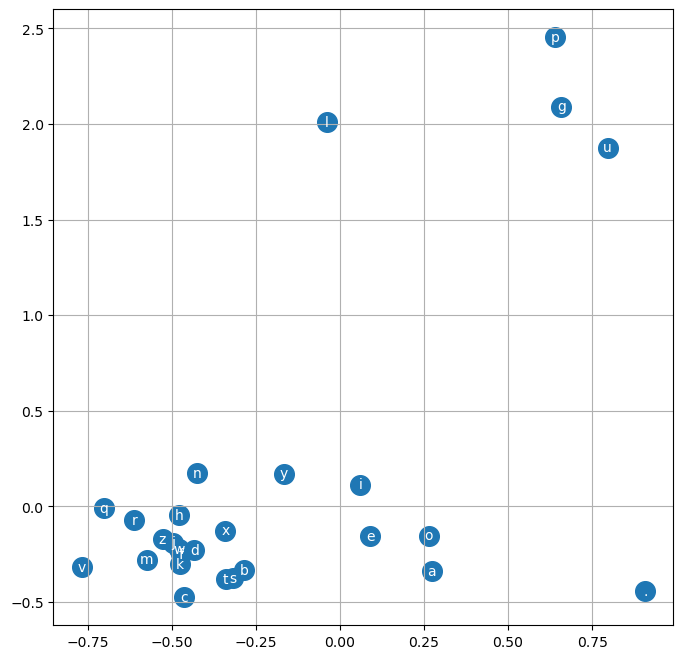

In [150]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [152]:
# Increase the parameters size to improve training

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

sum(p.nelement() for p in parameters) # total no. of parameters

11897

In [153]:
stepi, lossi, lri = [], [], []

In [164]:
for i in range(20000):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))
  
  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 10)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 200)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())   # log loss for better view instead of L shape, this will squash

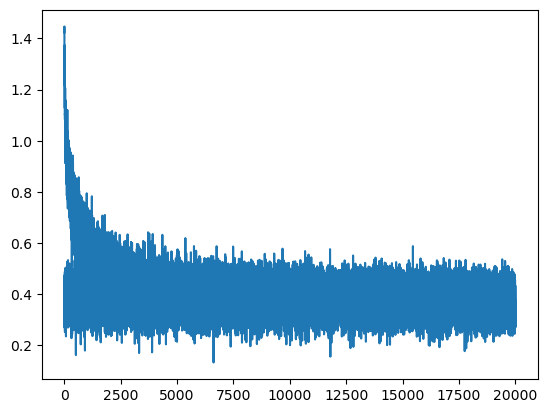

In [165]:
plt.plot(stepi, lossi) # noise is due to minibatch - gradient oscillates

In [166]:
# Evaluate the train set loss

emb = C[Xtr] 
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) 
logits = h @ W2 + b2 
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.3172, grad_fn=<NllLossBackward0>)

In [167]:
# Evaluate the val set loss

emb = C[Xdev] 
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) 
logits = h @ W2 + b2 
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.3429, grad_fn=<NllLossBackward0>)

### Sampling from the trained model

In [168]:
context = [0] * block_size
C[torch.tensor([context])].shape

torch.Size([1, 3, 10])

In [169]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):  # 20 sample words from the trained model
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1) 
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

eriah.
myah.
ree.
mad.
rham.
reverscendram.
raicee.
arlie.
emi.
jen.
eden.
ean.
aar.
elynn.
honel.
noselberghai.
jerick.
jowellee.
non.
canue.


In [170]:
probs.shape

torch.Size([1, 27])